# A Functional Data Analysis Framework for Positron Emission Tomography

Sepand Kashani, Michalina Pacholska

In [1]:
import helpers
import numpy as np
import scipy.sparse as sparse

import matplotlib.pyplot as plt
from skimage import color, transform

*Positron Emission Tomography* (PET) is a medical imaging technique to visualize metabolic processes in the body.
The goal of this session is two-fold:
* Apply the concepts of sampling and interpolation operators to the PET setup;
* Use various reconstruction algorithms to go from the data to images.

**Hint**: we provide a few helper functions in `helpers.py`.

PET is a nuclear imaging technique used to measure metabolic processes in the body.
The procedure is as follows:
* A radioactive tracer such as (marked) glucose is injected to the patient.
* Being an energy source, the tracer will naturally concentrate in regions with high metabolic activity and decay there.
* The radioactive decay produces positrons.
When a positron comes into contact with a free electron in the body, they spontaneously annihilate and eject 2 colinear gamma rays in a random direction.
* The gamma ray hits are counted on an $L$-element detector ring.

<img src="img/pet_setup.png" style="width: 50%;"/>

As the gamma rays part in opposite directions, they are detected by one of the $\binom{L}{2}$ *detector tubes* in the system.

<img src="img/detector_tube.png" style="width: 40%;"/>

Each detector tube $d$ can be characterized by 3 values:
* $\xi$ : unit vector in $[-1,1] \times [0,1]$ giving the direction of the tube;
* $p$ : distance of the tube from the origin (can be negative);
* $w$ : width of the tube.

Once the parameterization of each tube is known, the numerical approximation of the sampling operator $\Phi^{*} \in \mathbb{R}^{N_{\text{tube}} \times N_{\text{px}}}$ can be constructed from each tube space $\mathcal{T}_{d}$:
$$ \mathcal{T}_{d} = \left\{ v \in \mathcal{B}\left(0, 1\right) \;\;|\;\; p_{d} - \frac{w_{d}}{2} \le \langle v, \xi_{d} \rangle \le p_{d} + \frac{w_{d}}{2} \right\} $$

**Note**: contrary to what you saw in class, all basis functions do *not* have the same width $w$. Similar to what you saw in class however, each basis function may vary per tube-space and can take a particular shape (i.e. box function, raised_cosine, ...)

**Note**: for simplicity, we will assume that images $f: \mathbb{R} \times \mathbb{R} \to \mathbb{R}$ take the form
$$ f(x, y) = \sum_{k = 1}^{N_{px}} f_{k} \phi_{k}(x, y), $$ where $\phi_{k}(x, y) = \delta(x - x_{k}, y - y_{k})$.

# Part 1: Building the Sampling Operator

**Exercise**: complete the function `sampling_op` below such that, given tube parameters $(w_{d}, p_{d}, \xi_{d})$, constructs the discrete matrix $S \in N_{tube} \times N_{px}$ where the $k$-th row of $S$ represents a discrete approximation of the $k$-th detector tube (with triangular beamshape).

*Hint*: 
* each row of `S` should be extremely sparse due to the small width of each tube. Consider using `scipy.sparse.csr_matrix` to store the output.
* You can instead use dense matrices if preferred, but then use 40 detectors instead of 80.

In [9]:
def sampling_op(xi, p, w, N_height, N_width):
    """
    Numerical approximation of continuous-domain sampling operator with triangle beam-shape.
    
    Parameters
    ----------
    xi : :py:class:`~numpy.ndarray`
        (N_tube, 2) normal vector to tube. (Must lie in quadrant I or II.)
    p : :py:class:`~numpy.ndarray`
        (N_tube,) tube distance from origin. (Can be negative.)
    w : :py:class:`~numpy.ndarray`
        (N_tube,) tube width.
    N_height : int
        Number of uniform vertical spatial samples in [-1, 1].
    N_width : int
        Number of uniform horizontal spatial samples in [-1, 1].

    Returns
    -------
    S : :py:class:`~scipy.sparse.csr_matrix`
        (N_tube, N_height*N_width) sampling operator, where each row contains the basis function of
        the instrument (vectorized row-by-row).
    """
    # Generate grid
    X, Y = np.meshgrid(np.linspace(-1, 1, N_width), 
                       np.linspace(-1, 1, N_height))
    pixels = np.stack((X, Y), axis=-1).reshape((N_height * N_width, 2))
    
    # Only interested in pixels within unit circle
    pixels[np.linalg.norm(pixels, axis=-1) >= 1] = 0
    
    N_tube = p.shape[0]    
    S = np.zeros((N_tube, N_height * N_width))
    for row in range(N_tube):
        projection = pixels @ xi[row]
        x = (projection - p[row]) * (2 / w[row])
        mask = ((np.abs(x) <= 1)         &  # inner/outer boundary
                ~np.isclose(projection, 0))    # circular boundary
        S[row, mask.nonzero()] = (-0.5 <= x[mask]) & (x[mask] <= 0.5)
    
    return sparse.csr_matrix(S)


N_detector = 80
N_h = N_w = 256
N_px = N_h * N_w

d_x, d_xi, d_p, d_w = helpers.tube_decomposition(N_detector)
S = sampling_op(d_xi, d_p, d_w, N_h, N_w)

**Exercise**: verify that your implementation of `sampling_op` is correct by plotting a few tube spaces.

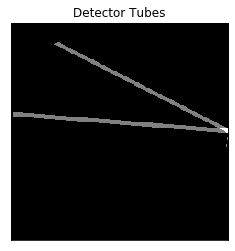

In [10]:
fig, ax = plt.subplots()
helpers.draw_tubes(S, N_h, N_w, [1, 40, 50], ax)

plt.show()

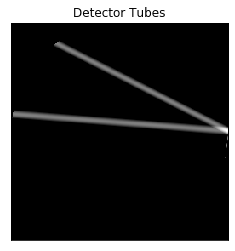

In [11]:
fig, ax = plt.subplots()
S = sparse.load_npz('sampling_matrix.npz')
helpers.draw_tubes(S, N_h, N_w, [1, 40, 50], ax)

plt.show()

## Part 2: Generating Sample Data

To explore different reconstruction algorithms below, we need to generate some PET measurements from an object.
Gamma ray emissions from the annihilation process can be modeled as a Poisson process $P(\lambda)$, where $\lambda(x, y) \in \mathbb{R}^{2}$ is the intensity function of the process. 
$N_{\text{tube}}$ samples from the PET detector can then be obtained by sampling $P(\lambda)$ in the detector cavity and applying `S` on it:

$$ N = S Z, \qquad Z \sim P(\lambda). $$

For conveniency, we will take the intensity function $\lambda$ as some grayscale image.

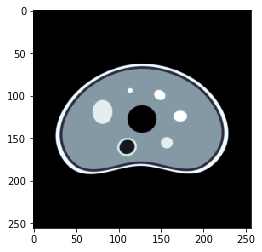

In [13]:
def get_intensity(path_img, max_rate=1e6):
    """
    Parameters
    ----------
    path_img  
    """
    lambda_rgb = plt.imread(path_img).astype(float)
    lambda_ = color.rgb2gray(lambda_rgb)
    
    # We pad the image with zeros so that the mask does not touch the detector ring.
    lambda_ = np.pad(lambda_, np.r_[N_h, N_w] // 3, mode='constant')
    lambda_ = transform.resize(lambda_, (N_h, N_w), order=1, mode='constant')
    lambda_ *= max_rate / lambda_.max()  # (N_h, N_w)

    lambda_ = lambda_
    return lambda_

path_img = './img/phantom_3.png' # check the img/ directory for alternatives
lambda_ = get_intensity(path_img)

fig, ax = plt.subplots()
ax.imshow(lambda_, cmap='bone');

**Exercise**: Generate samples from the PET scanner by
* sampling a Poisson random variable where pixel $k$ follows $P(\lambda_{k})$;
* measurement the Poisson realization through the sampling operator `S`.

In [36]:
sample = S @ lambda_.reshape((N_h * N_w,))

**Exercise**: plot the sinogram associated with the measurements obtained above. Do you see the sinusoidal patterns?

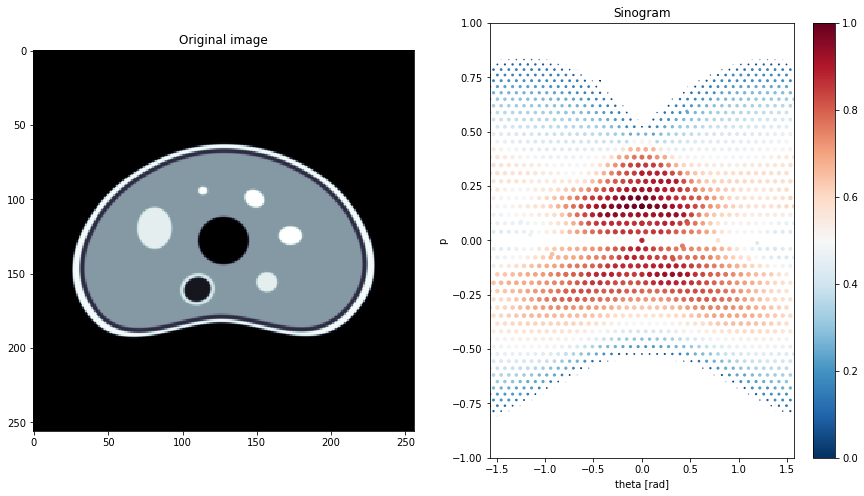

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(15,8))
helpers.plot_image(lambda_, 'Original image', ax[0])
helpers.sinogram(d_xi, d_p, sample, ax[1])
plt.show()

**Exercise**: Let $\lambda$ be the all-zero vector, except in 5 random locations where it takes value 1. Plot the sinogram of the measurements now.

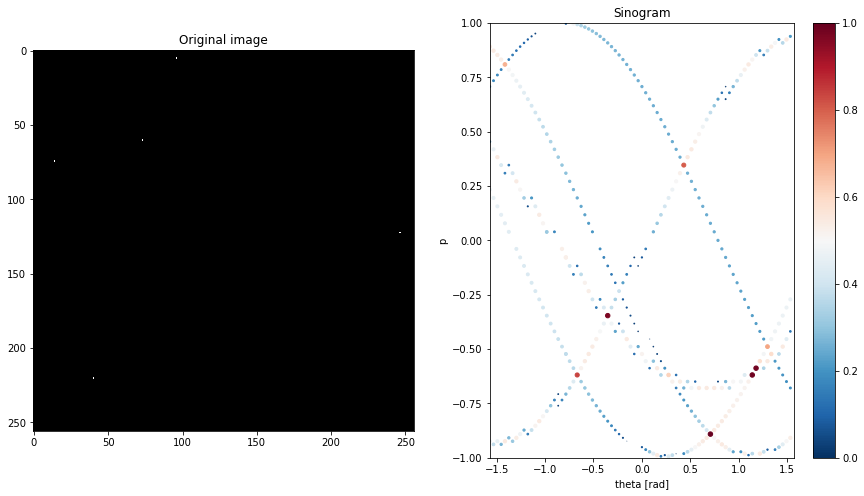

In [38]:
lambda_rnd = np.zeros((N_h, N_w))
lambda_rnd[np.random.randint(N_h, size=5), np.random.randint(N_w, size=5)] = 1

sample_rnd = S @ lambda_rnd.reshape((N_h * N_w,))

fig, ax = plt.subplots(1, 2, figsize=(15,8))
helpers.plot_image(lambda_rnd, 'Original image', ax[0])
helpers.sinogram(d_xi, d_p, sample_rnd, ax[1])
plt.show()

## Part 3: Reconstruction Algorithms

Now that we have data from a PET scanner, let's try and reconstruct the ground-truth using various algorithms.

**Exercise**: 
1. Complete the `backprojection` function below that estimates the ground truth using the backprojection algorithm. 
2. Generate measurement samples from `lambda_` above and plot the backprojection image.

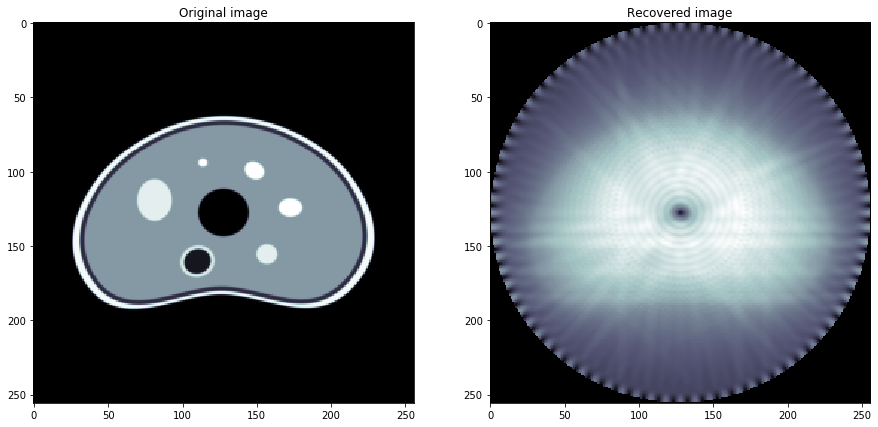

In [39]:
def backprojection(S, N):
    """
    Form image via backprojection.

    Parameters
    ----------
    S : :py:class:`~scipy.sparse.csr_matrix`
        (N_tube, N_px) sampling operator.
    N : :py:class:`~numpy.ndarray`
        (N_tube,) PET samples

    Returns
    -------
    I : :py:class:`~numpy.sparse.csr_matrix`
        (N_px,) vectorized image
    """
    return S.T @ N

fig, ax = plt.subplots(1, 2, figsize=(15,8))
helpers.plot_image(lambda_, 'Original image', ax[0])
helpers.plot_image(backprojection(S, sample).reshape(N_h, N_w),
                   'Recovered image with backprojection', ax[1])
plt.show()

**Exercise**: 
1. Complete the `least_squares` function below that estimates the ground truth using the least_squares algorithm. 
2. Generate measurement samples from `lambda_` above and plot the least_squares image.

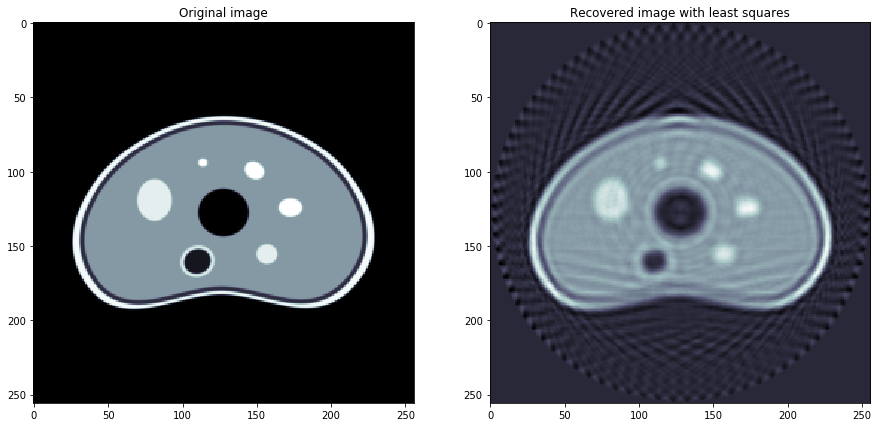

In [47]:
def least_squares(S, N):
    """
    Form image via least-squares.

    Parameters
    ----------
    S : :py:class:`~scipy.sparse.csr_matrix`
        (N_tube, N_px) sampling operator.
    N : :py:class:`~numpy.ndarray`
        (N_tube,) PET samples

    Returns
    -------
    I : :py:class:`~numpy.sparse.csr_matrix`
        (N_px,) vectorized image
    """    
    return S.T @ np.linalg.pinv((S @ S.T).toarray()) @ N 

fig, ax = plt.subplots(1, 2, figsize=(15,8))
helpers.plot_image(lambda_, 'Original image', ax[0])
helpers.plot_image(least_squares(S, sample).reshape(N_h, N_w),
                   'Recovered image with least squares', ax[1])
plt.show()

**Exercise**: 
1. Complete the `kaczmarz` function below that estimates the ground truth using Kaczmarz's algorithm. 
2. Generate measurement samples from `lambda_` above and plot the Kaczmarz image.

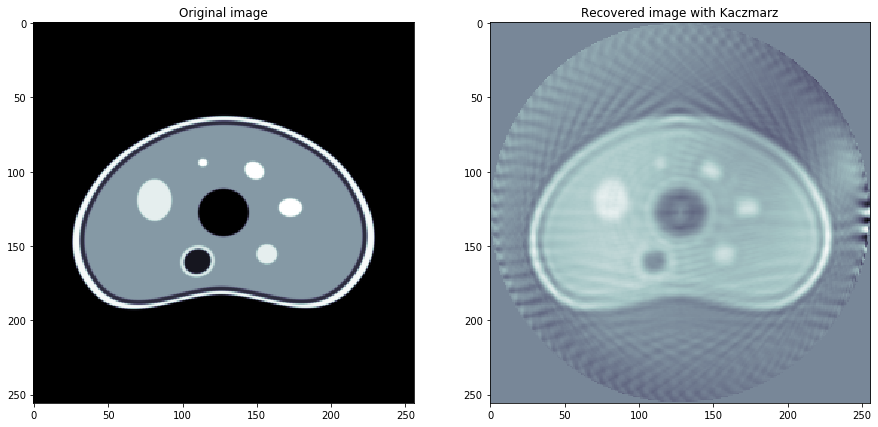

In [62]:
def kaczmarz(S, N, N_iter, I0):
    """
    Form image via Kaczmarz's algorithm.

    Parameters
    ----------
    S : :py:class:`~scipy.sparse.csr_matrix`
        (N_tube, N_px) sampling operator.
    N : :py:class:`~numpy.ndarray`
        (N_tube,) PET samples
    N_iter : int
        Number of iterations to perform.
    I0 : :py:class:`~numpy.ndarray`
        (N_px,) initial point of the optimization.

    Returns
    -------
    I : :py:class:`~numpy.ndarray`
        (N_px,) vectorized image
    """
    I = np.copy(I0)
    N_tube = len(N)
    
    for i in range(N_iter):
        row = i % N_tube
        r = S[row].toarray()[0]
        l = r @ r

        if ~np.isclose(l, 0):
            # `l` can be very small, in which case it is dangerous to do the rescale. 
            # We'll simply drop these degenerate basis vectors.
            scale = (N[row] - r @ I) / l
            I += scale * r
    return I

fig, ax = plt.subplots(1, 2, figsize=(15,8))
helpers.plot_image(lambda_, 'Original image', ax[0])
helpers.plot_image(kaczmarz(S, sample, 5 * len(sample), np.zeros((N_px,))).reshape(N_h, N_w),
                   'Recovered image with Kaczmarz', ax[1])
plt.show()